Malaria Detektering

Denne journaler baseret på National Institute of Healths (NIH) officielle Malaria dataset:
https://ceb.nlm.nih.gov/repositories/malaria-datasets/. 

Datasettet indeholder 27.558 billeder af celler, hvoraf halvdelen er sunde celler og den anden halvdel er smittede celler. Vi fandt dette dataset på Kaggle, hvor vi valgte dette og besluttede os for, at bygge en form for Malaria detektering der kan skelne mellem sunde og smittede celler.


Step by step (HOML, chapter 2):
- Get the data
- Create a test set
- Discover and visualize the data to gain insight
- Prepare the data for machine learning algorithms
- Select and train a model
- Fine-tune your model


In [1]:
# Imports and from
import os
import cv2
import pandas as pd
import numpy as np
import keras

from pylab import *
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from keras.utils import np_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.models import Sequential
from keras import optimizers

#For GPU cluster
from libitmal import kernelfuns as itmalkernelfuns
itmalkernelfuns.EnableGPU()

print('ok')


Using TensorFlow backend.


ok


In [ ]:
# Downloading and extracting.
# Only on first run
!wget = https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip 
!unzip cell_images.zip

Vi har nu downloaded og udpakket datasettet og fortsætter nu med at definere deres path i to variabler.

In [2]:
parasitized = os.listdir('/home/itmalgrp04/cell_images/Parasitized')
uninfected = os.listdir('/home/itmalgrp04/cell_images/Uninfected')

#parasitized = os.listdir('/Users/oscarp/Documents/Malaria_J3/cell_images/Parasitized')
#uninfected = os.listdir('/Users/oscarp/Documents/Malaria_J3/cell_images/Uninfected')



For at bedre forstå forskellen mellem sunde (Uninfected) og smittede (Parasitized) celler, vil vi plotte 10 af billeder, hhv. 5 Uninfected og 5 Parasitized celler.

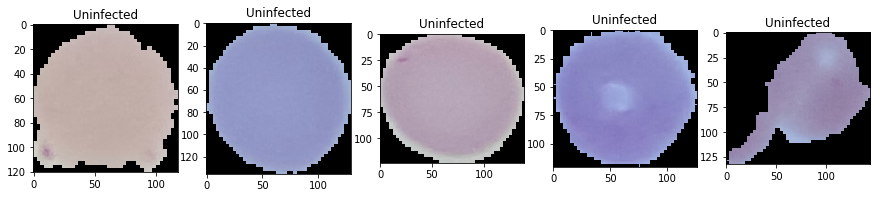

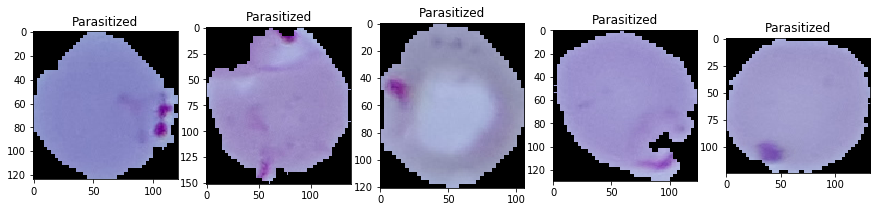

In [3]:
plt.figure(figsize = (15,15))
# Loop til at plotte 5 billeder af sunde celler
for i in range(5):
    plt.subplot(1, 5, i+1)
    #img = cv2.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Uninfected' + "/" + uninfected[i+1])
    img = cv2.imread('/home/itmalgrp04/cell_images/Uninfected' + "/" + uninfected[i+1])


    plt.title('Uninfected')
    plt.imshow(img)
plt.show()

plt.figure(figsize = (15,15))
# Loop til at plotte 5 billeder af smittede celler
for i in range(5):
    plt.subplot(1, 5, i+1)
    #img = cv2.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Parasitized' + "/" + parasitized[i])
    img = cv2.imread('/home/itmalgrp04/cell_images/Parasitized' + "/" + parasitized[i])


    plt.title('Parasitized')
    plt.imshow(img)
plt.show()

Kigger vi efter på plottene ovenover er det tydeligt at se, at billederne ikke skalerer på samme måde. Dette kunne ende ud i problemer senere. For at fikse dette, skal alle billederne skaleres på præcis samme måde. Næste punkt er derfor "Data Preparation". 

Her vil vi oprette data og labels lister. Data listen vil blive brugt til at indeholde de nyligt image_to_array konverterede billeder. Labels listen vil indeholde hhv 0 og 1 for de to klasser (Parasitized og Uninfected).

In [4]:
labels = []
data = []

for img in parasitized:
    try:
        # Indlæser billede
        #img_read = plt.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Parasitized' + "/" + img)
        img_read = plt.imread('/home/itmalgrp04/cell_images/Parasitized' + "/" + img)

        # Tilpasser størrelsen efter egne specifikationer
        img_resize = cv2.resize(img_read, (50, 50))
        # Konverterer et PIL image til et Numpy array
        img_array = img_to_array(img_resize)
        # Adder til data listen
        data.append(img_array)
        # Adder til labels listen. Værdi 1 når Parasitized. I næste section er det værdien0, når Uninfected
        labels.append(1)
    except:
        None
        
        # Gentages for de sunde celler
for img in uninfected:
    try:
        #img_read = plt.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Uninfected' + "/" + img)
        img_read = plt.imread('/home/itmalgrp04/cell_images/Uninfected' + "/" + img)

        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

In [5]:
# Assigner array med data og labels til nye variabler
Cells = np.array(data)
Labels = np.array(labels)

In [6]:
# Får dimensionerne af arrayet og blander dem.
a = np.arange(Cells.shape[0])
np.random.shuffle(a)
Cells = Cells[a]
Labels = Labels[a]

Et dataset på 27.558 billeder er i et sådant tilfælde, ikke særligt stort. Data augmentation (øge mængden af data), kunne derfor være spændende at lege med. Udover at data augmentation er oplagt at bruge når man har en forholdsvis lille datamængde, forhindrer det desuden modellen i at se det præcis samme billede flere gange.
I første omgang fortsætter vi dog uden, for muligvis at vende tilbage, hvis resultatet ikke blev godt nok og forhåbentligt påvise en positiv forskel.

I nedenstående afsnit påbegynder vi et Train/test split af vores dataset på 20%. 

In [7]:
# Train/test split på 20% og med random_state parameter
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Cells, Labels, test_size = 0.2, random_state = 101)

Da vores classifier har flere klasser (N=2), vil det sidste output lag i vore Neurale netværk have to neuroner, en for hver klasse. Her vil One Hot Encoding hjælpe os med, at ændre vores labels i binær format. 

Dette kunne også gøres i vores data augmentation, ved at sætte class_mode til "categorical", men i første omgang prøver vi som sagt uden data augmentation.

In [8]:
# One Hot Encoding på både vores train og test set.

y_train = np_utils.to_categorical(y_train,2)
y_test = np_utils.to_categorical(y_test,2)

# Print for overblik
print("Training data:",x_train.shape, "Training labels:", y_train.shape)
print("Test data:", x_test.shape, "Test labels:", y_test.shape)


Training data: (22046, 50, 50, 3) Training labels: (22046, 2)
Test data: (5512, 50, 50, 3) Test labels: (5512, 2)


Af ovenstående print kan vi konkludere, at vi med success har fået oprettet et Train/test med 20%. 
Output at printet skal forstås på følgende måde:

Training data: (22046, 50, 50, 3)
- Det første tal er antallet af billeder.
- Det andet og tredje tal er length og width på billedet. Dette definerede vi højere oppe da vi preparerede vores data
- Det fjerde og sidste tal er 3, og er dette da vi har et 3-kanals RGB billede

Training labels: (22046, 2)
- Det første tal er igen antallet af billeder.
- Det sidste tal er antallet af klasser: Parasitized & Uninfected

# CNN Model

Næste step vil nu være at bygge vores Convolutional Neural Network (CNN) model. CNN er i særdeleshed kendetegnet ved at være fordelagtigt at bruge til billedgenkendelse, billed klassifikation og lignende. En CNN klassifikations model som denne vi gerne vil bygge, fungerer ved, at tage et input billede, processere det og klassificere det i en bestemt kategori (Parasitized eller Uninfected). Helt konkret bliver hvert billede sendt igennem en række Convolution layers med diverse filtre, en form for Pooling og til sidst tilføjer vi en Softmax funktion til at klassificere et billede med en værdi mellem 0 og 1.

Kigger vi nedenstående block, ses vores CNN model.
Her køres der med tre Convulution layers (Conv2D). 
- Den første parameter er antallet af filtre, der stiger i takt med dybden af netværket. Vores tre Conv2D lag er derfor med 16, 32 og 64 filtre.
- Det andet parameter siger noget om størrelser af disse convolution filtre. en kernel_size på 2 er her lig med 2x2.
- Den næste parameter er padding="same", der bibeholder vores spatiale volume, forstået på måde, at vores output størrelse matcher vores input størrelse. 
- Som activation funktionfaldt valget på reLU (Rectified Linear Unit). - - Den sidste parameter i vores første lag er simpelthen bare (width, height, channels).

Efter hvert Conv2D lag, tilføjer vi en MaxPooling2D funktion. Dette gøres for at down-sample, og derved bliver output mindre end input. At vi har valgt MaxPooling from for f.eks. AveragePooling betyder helt konkret, at vi i det 2D input vindue vælger de maksimale værdier til at være vores output.

Vi tilføjer nu et Dropout lag for at forebygge overfitting. Dette gøres ofte hvis netværket er for stort, hvis man træner for længe eller evt. ikke har nok data.

Da vi gerne vil benytte denne data i et neuralt netværk, flader vi dataen ud fra et map til en kolonne, groft beskrevet.

Der følger nu en række dense og dropout lag der fungerer som vores fully-connected layers. I sidste lag benyttes der activation="softmax", idet vi gerne vil have outputtet en probability på mellem 0 og 1. Som tidligere nævnt, er Softmax derfor helt oplagt til multi-klassifikation.


In [9]:
#CNN model uden data augmentation
# https://keras.io/layers/convolutional/

#Laver den til en function så den kan genbruges
def CNN(height, width, classes, channels):
    model=Sequential()

    model.add(Conv2D(filters=16,
                 kernel_size=2,
                 padding="same",
                 activation="relu",
                 input_shape=(50,50,3)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32,
                 kernel_size=2,
                 padding="same",
                 activation="relu"))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64,
                 kernel_size=2,
                 padding="same",
                 activation="relu"))
    model.add(MaxPooling2D(pool_size=2))

    # For at undgå overfitting
    model.add(Dropout(0.5))
    # Flader ud så kan benyttes senere
    model.add(Flatten())
    model.add(Dense(750,activation="relu"))
    model.add(Dropout(0.5))

    # Softmax var det naturlige valg, da vi har mere end én klasse af klassificere, hvor sigmoid måske
    # er mere rettet mod binære. 2 er outpay layer neuroner
    model.add(Dense(2,activation="softmax"))
    return model

model = CNN(50, 50, 2, 3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
__________

Ifht. valget af optimizer faldet vi over en artikel der sammenlignede de forskellige optimizers:
https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/

Denne viste, at Adam/Nadam ville være et fint valg til vores formål.

*UDDYB HER*

In [10]:
# Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc','mse'])
m = model.fit(x_train,y_train,batch_size=50,epochs=20, validation_data=(x_test, y_test),verbose=1)

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 3s 156us/step - loss: 0.4631 - acc: 0.7546 - mean_squared_error: 0.1539 - val_loss: 0.1793 - val_acc: 0.9459 - val_mean_squared_error: 0.0464
Epoch 2/20
22046/22046 [==============================] - 3s 131us/step - loss: 0.1723 - acc: 0.9449 - mean_squared_error: 0.0452 - val_loss: 0.1669 - val_acc: 0.9496 - val_mean_squared_error: 0.0426
Epoch 3/20
22046/22046 [==============================] - 3s 117us/step - loss: 0.1550 - acc: 0.9521 - mean_squared_error: 0.0398 - val_loss: 0.1475 - val_acc: 0.9546 - val_mean_squared_error: 0.0379
Epoch 4/20
22046/22046 [==============================] - 3s 117us/step - loss: 0.1475 - acc: 0.9522 - mean_squared_error: 0.0386 - val_loss: 0.1424 - val_acc: 0.9559 - val_mean_squared_error: 0.0369
Epoch 5/20
22046/22046 [==============================] - 3s 118us/step - loss: 0.1406 - acc: 0.9549 - mean_squared_error: 0.0369 - val_loss: 0.1380 - 

In [11]:
#Evaluerer modellen på test data
evaluation = model.evaluate(x_test, y_test, verbose=1)
print("Eval Accuracy:",evaluation[1], "Eval loss:", evaluation[0])

5512/5512 [==============================] - 0s 61us/step
Eval Accuracy: 0.9615384615384616 Eval loss: 0.13172813410855863


In [12]:
# Opretter Klassifikations rapport (Performance Metric)
LabelPredict = model.predict(x_test,batch_size=50, verbose=1)
print(classification_report(y_test, np_utils.to_categorical(LabelPredict.argmax(axis=1),2))) 

5512/5512 [==============================] - 0s 43us/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2795
           1       0.97      0.96      0.96      2717

   micro avg       0.96      0.96      0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512
 samples avg       0.96      0.96      0.96      5512



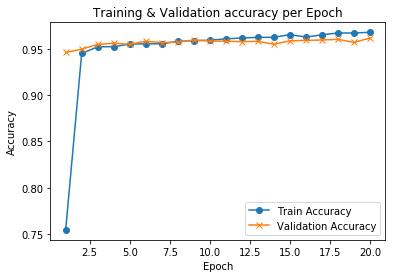

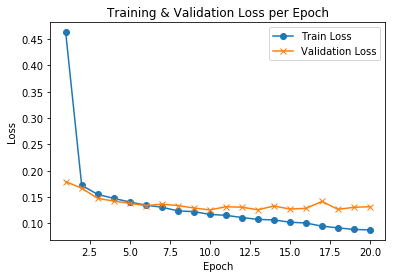

In [13]:
# Plotter data for bedre visuel forståelse

#Accuracy
a, ax = plt.subplots()

ax.set_title('Training & Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot([None] + m.history['acc'], 'o-')
ax.plot([None] + m.history['val_acc'], 'x-')
ax.legend(['Train Accuracy', 'Validation Accuracy'])

#Loss
b, ax = plt.subplots()

ax.set_title('Training & Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot([None] + m.history['loss'], 'o-')
ax.plot([None] + m.history['val_loss'], 'x-')
ax.legend(['Train Loss','Validation Loss'], loc = 0)

# SGD Optimizer

Da CNN er blevet defineret som en funktion, er det nemt at udskifte optimizeren uden for meget redundant kode. I nedenstående blok, er der forsøgt med en SGD optimizer uden specielle parametre.

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 2s 101us/step - loss: 0.6909 - acc: 0.5287 - val_loss: 0.6772 - val_acc: 0.6362
Epoch 2/20
22046/22046 [==============================] - 3s 117us/step - loss: 0.6691 - acc: 0.5983 - val_loss: 0.6487 - val_acc: 0.6021
Epoch 3/20
22046/22046 [==============================] - 2s 103us/step - loss: 0.6379 - acc: 0.6374 - val_loss: 0.6118 - val_acc: 0.6626
Epoch 4/20
22046/22046 [==============================] - 2s 103us/step - loss: 0.6101 - acc: 0.6711 - val_loss: 0.5673 - val_acc: 0.7141
Epoch 5/20
22046/22046 [==============================] - 2s 103us/step - loss: 0.5776 - acc: 0.7073 - val_loss: 0.5351 - val_acc: 0.7524
Epoch 6/20
22046/22046 [==============================] - 2s 103us/step - loss: 0.5405 - acc: 0.7475 - val_loss: 0.4996 - val_acc: 0.7712
Epoch 7/20
22046/22046 [==============================] - 2s 103us/step - loss: 0.4793 - acc: 0.8136 - val_loss: 0.4164 - v

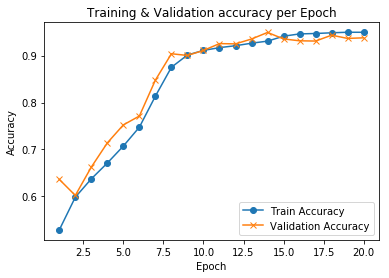

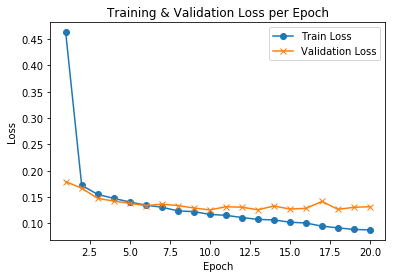

In [14]:
#Test with different optimizer

model_SGD = CNN(50,50,2,3)
model_SGD.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['acc'])

m_SGD = model_SGD.fit(x_train,y_train,batch_size=50,epochs=20, validation_data=(x_test, y_test),verbose=1)

a, ax = plt.subplots()

ax.set_title('Training & Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot([None] + m_SGD.history['acc'], 'o-')
ax.plot([None] + m_SGD.history['val_acc'], 'x-')
ax.legend(['Train Accuracy', 'Validation Accuracy'])

b, ax = plt.subplots()

ax.set_title('Training & Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot([None] + m.history['loss'], 'o-')
ax.plot([None] + m.history['val_loss'], 'x-')
ax.legend(['Train Loss','Validation Loss'], loc = 0)

LabelPredict = model_SGD.predict(x_test,batch_size=50, verbose=1)
print(classification_report(y_test, np_utils.to_categorical(LabelPredict.argmax(axis=1),2))) 

# SGD Optimizer with tuned parameters

Vi gentager nu med en SGD Optimizer, men benytter denne gang Keras anbefalede parametre (learning rate, momentum, nesterov mm.)

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 2s 104us/step - loss: 0.5594 - acc: 0.7042 - val_loss: 0.3841 - val_acc: 0.9300
Epoch 2/20
22046/22046 [==============================] - 3s 114us/step - loss: 0.2256 - acc: 0.9298 - val_loss: 0.2245 - val_acc: 0.9200
Epoch 3/20
22046/22046 [==============================] - 3s 114us/step - loss: 0.1770 - acc: 0.9442 - val_loss: 0.1817 - val_acc: 0.9327
Epoch 4/20
22046/22046 [==============================] - 3s 113us/step - loss: 0.1597 - acc: 0.9512 - val_loss: 0.1569 - val_acc: 0.9510
Epoch 5/20
22046/22046 [==============================] - 2s 113us/step - loss: 0.1558 - acc: 0.9523 - val_loss: 0.1522 - val_acc: 0.9508
Epoch 6/20
22046/22046 [==============================] - 3s 114us/step - loss: 0.1503 - acc: 0.9536 - val_loss: 0.1600 - val_acc: 0.9456
Epoch 7/20
22046/22046 [==============================] - 3s 114us/step - loss: 0.1451 - acc: 0.9555 - val_loss: 0.1491 - v

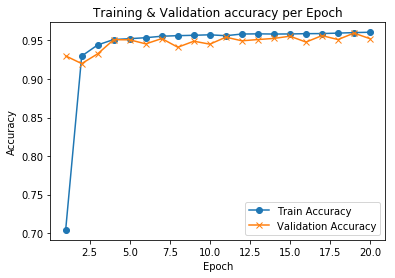

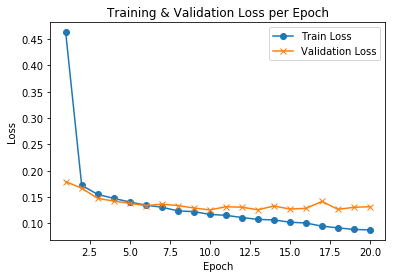

In [15]:
#Test with different optimizer

model_SGD_Param = CNN(50,50,2,3)

sgdParam = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_SGD_Param.compile(loss='categorical_crossentropy', optimizer=sgdParam, metrics=['acc'])

m_SGD_Param = model_SGD_Param.fit(x_train,y_train,batch_size=50,epochs=20, validation_data=(x_test, y_test),verbose=1)

a, ax = plt.subplots()

ax.set_title('Training & Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot([None] + m_SGD_Param.history['acc'], 'o-')
ax.plot([None] + m_SGD_Param.history['val_acc'], 'x-')
ax.legend(['Train Accuracy', 'Validation Accuracy'])

b, ax = plt.subplots()

ax.set_title('Training & Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot([None] + m.history['loss'], 'o-')
ax.plot([None] + m.history['val_loss'], 'x-')
ax.legend(['Train Loss','Validation Loss'], loc = 0)

LabelPredict = model_SGD_Param.predict(x_test,batch_size=50, verbose=1)
print(classification_report(y_test, np_utils.to_categorical(LabelPredict.argmax(axis=1),2))) 

# Nadam optimizer

I næste blok tester vi med Nadam optimizeren. I modsætning til Adam optimizeren der i bund og grund er en RMSprop med momentum, er Nadam en Adam RMSprop med Nesterov momentum. Denne vil vi nu teste med Kera dokumentationens officielle parametre.

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 3s 150us/step - loss: 0.3757 - acc: 0.8177 - val_loss: 0.1788 - val_acc: 0.9381
Epoch 2/20
22046/22046 [==============================] - 3s 129us/step - loss: 0.1566 - acc: 0.9509 - val_loss: 0.1577 - val_acc: 0.9530
Epoch 3/20
22046/22046 [==============================] - 3s 130us/step - loss: 0.1468 - acc: 0.9551 - val_loss: 0.1430 - val_acc: 0.9577
Epoch 4/20
22046/22046 [==============================] - 3s 129us/step - loss: 0.1413 - acc: 0.9550 - val_loss: 0.1409 - val_acc: 0.9563
Epoch 5/20
22046/22046 [==============================] - 3s 133us/step - loss: 0.1434 - acc: 0.9550 - val_loss: 0.1635 - val_acc: 0.9490
Epoch 6/20
22046/22046 [==============================] - 3s 129us/step - loss: 0.1383 - acc: 0.9575 - val_loss: 0.1278 - val_acc: 0.9597
Epoch 7/20
22046/22046 [==============================] - 3s 130us/step - loss: 0.1294 - acc: 0.9587 - val_loss: 0.1251 - v

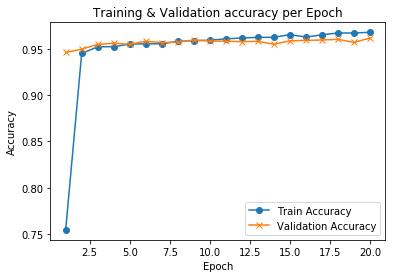

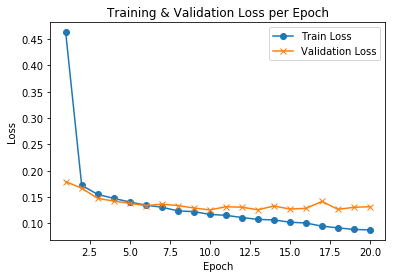

In [24]:
#Test with different optimizer
model_Nadam = CNN(50,50,2,3)

nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model_Nadam.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['acc'])

m_Nadam = model_Nadam.fit(x_train,y_train,batch_size=50,epochs=20, validation_data=(x_test, y_test),verbose=1)

#Accuracy
a, ax = plt.subplots()
ax.set_title('Training & Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot([None] + m.history['acc'], 'o-')
ax.plot([None] + m.history['val_acc'], 'x-')
ax.legend(['Train Accuracy', 'Validation Accuracy'])

#Loss
b, ax = plt.subplots()
ax.set_title('Training & Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot([None] + m.history['loss'], 'o-')
ax.plot([None] + m.history['val_loss'], 'x-')
ax.legend(['Train Loss','Validation Loss'], loc = 0)

LabelPredict = model_Nadam.predict(x_test,batch_size=50, verbose=1)
print(classification_report(y_test, np_utils.to_categorical(LabelPredict.argmax(axis=1),2))) 

In [25]:
# Plotter confusion matrix:

import sklearn.metrics as metrics
LabelPredict1 = model_Nadam.predict(x_test,batch_size=50, verbose=1)
print(metrics.confusion_matrix(y_test.argmax(axis=1), LabelPredict1.argmax(axis=1)))

5512/5512 [==============================] - 0s 59us/step
[[2696   99]
 [ 120 2597]]


TODO: 
- skriv om resultaterne. 
- Forklar Performance Metric ifht resultaterne:
https://muthu.co/understanding-the-classification-report-in-sklearn/
- Skriv om Confusion Matrix.
- Konklusion
- Personlige Konklusion

# Konklusion
Generelt:

- Gode resultater påtrods at simpel opbygning.
- Viser sig, at Adam optimizer er noget bedre samt hurtigere end standard SGD (pr. 25/5, kl. 16:56)
- Generelt viser at vi alle har være pressede med bachelor, ITMAL, ROB2 afleveringer alle inden for den samme uge. 
- A cool project could be to take the pretrained VGG-19 model, fine tune it and add data augmentation


Oscar Ohrt Pradel:

 - Spændende at få lov til at gå i dyben og nørde lidt CNNs på et dataset man selv har valgt og syntes er fedt.
 - Imponeret over hvor godt der blev performed på så "lidt" data.
 - Mere tid/overskud kunne man have kigget på data augmentation, men med dette resultat, er det ikke nødvendigt.   Heller ikke 100% at det ville hjælpe
 - Har fået en langt bedre forståelse for hvornår hvilke Activations burde bruges, ifht. tillært i J1 og J2
 - Spændende at dykke dybere ned i Performance metrix og udvælge den helt rigtige til denne case.

Andreas Blaabjerg:

Stanisislav Lunderskov:

Victor Mogharrabian Fard:

